In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from IPython.display import display, HTML
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("./data/processed/final_dataset.csv",encoding="utf-8")

In [3]:
print(data.dtypes)
labels = data["topic"]
true_k = np.unique(labels).shape[0]

Unnamed: 0         int64
attitude          object
hashtags          object
id                 int64
processed_text    object
raw_text          object
seed_topic        object
topic             object
dtype: object


In [4]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_vectorizer = TfidfVectorizer( max_df=.7,min_df=5,ngram_range=(1,3),tokenizer=tokenize)
%time tfidf_matrix = text_vectorizer.fit_transform(data['processed_text'])
print("X vector n_samples: %d, n_features: %d" % tfidf_matrix.shape)

CPU times: user 1min 7s, sys: 3.08 s, total: 1min 10s
Wall time: 1min 13s
X vector n_samples: 123457, n_features: 119141


## Calculate Cosine Distances Between the Documents of Each Topic

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

unique_topics = np.unique(data['topic'])
result = []
calculated = []
for x_topic in unique_topics: 
    for y_topic in unique_topics:
        calc_topics = sorted((x_topic,y_topic))
        if calc_topics not in calculated:
            x_docs = tfidf_matrix[np.ix_(data['topic']==x_topic)]
            y_docs = tfidf_matrix[np.ix_(data['topic']==y_topic)]
            print(x_topic,y_topic)
            #print(x_docs.shape,y_docs.shape)
            cosine_distance = 1 - cosine_similarity(x_docs, y_docs)
            result.append({'x_topic': x_topic, 'y_topic': y_topic, 'mean_distance': cosine_distance.mean()})
            calculated.append(calc_topics)
df = pd.DataFrame.from_dict(result)

(u'CarManufacturer', u'CarManufacturer')
(u'CarManufacturer', u'FastFood')
(u'CarManufacturer', u'Movies')
(u'CarManufacturer', u'Musician')
(u'CarManufacturer', u'Series')
(u'CarManufacturer', u'Soccer')
(u'CarManufacturer', u'Technology')
(u'CarManufacturer', u'USPolitican')
(u'FastFood', u'FastFood')
(u'FastFood', u'Movies')
(u'FastFood', u'Musician')
(u'FastFood', u'Series')
(u'FastFood', u'Soccer')
(u'FastFood', u'Technology')
(u'FastFood', u'USPolitican')
(u'Movies', u'Movies')
(u'Movies', u'Musician')
(u'Movies', u'Series')
(u'Movies', u'Soccer')
(u'Movies', u'Technology')
(u'Movies', u'USPolitican')
(u'Musician', u'Musician')
(u'Musician', u'Series')
(u'Musician', u'Soccer')
(u'Musician', u'Technology')
(u'Musician', u'USPolitican')
(u'Series', u'Series')
(u'Series', u'Soccer')
(u'Series', u'Technology')
(u'Series', u'USPolitican')
(u'Soccer', u'Soccer')
(u'Soccer', u'Technology')
(u'Soccer', u'USPolitican')
(u'Technology', u'Technology')
(u'Technology', u'USPolitican')
(u'USPo

# Scale and Visualize the Distances

y_topic,CarManufacturer,FastFood,Movies,Musician,Series,Soccer,Technology,USPolitican
x_topic,,,,,,,,
CarManufacturer,0.983489,0.986893,0.988346,0.986680,0.987369,0.986730,0.986695,0.985273
FastFood,NaN,0.987424,0.989406,0.988114,0.988675,0.988281,0.988268,0.987076
Movies,NaN,NaN,0.986805,0.989050,0.988852,0.989137,0.989340,0.988239
Musician,NaN,NaN,NaN,0.986391,0.987614,0.987011,0.986978,0.985328
Series,NaN,NaN,NaN,NaN,0.986655,0.987519,0.987504,0.985941
Soccer,NaN,NaN,NaN,NaN,NaN,0.985829,0.987039,0.984663
Technology,NaN,NaN,NaN,NaN,NaN,NaN,0.985639,0.985289
USPolitican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980136


y_topic,CarManufacturer,FastFood,Movies,Musician,Series,Soccer,Technology,USPolitican
x_topic,,,,,,,,
CarManufacturer,0.361681,0.728875,0.885668,0.705935,0.780198,0.711349,0.707558,0.554104
FastFood,NaN,0.786203,1.000000,0.860609,0.921130,0.878618,0.877230,0.748605
Movies,NaN,NaN,0.719424,0.961590,0.940206,0.970987,0.992899,0.874135
Musician,NaN,NaN,NaN,0.674782,0.806681,0.741677,0.738018,0.560040
Series,NaN,NaN,NaN,NaN,0.703244,0.796432,0.794762,0.626166
Soccer,NaN,NaN,NaN,NaN,NaN,0.614172,0.744660,0.488337
Technology,NaN,NaN,NaN,NaN,NaN,NaN,0.593629,0.555828
USPolitican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


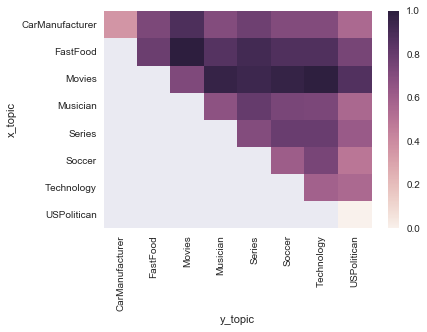

In [71]:
mean_distance_matrix = df.groupby(['x_topic','y_topic'])["mean_distance"].mean().unstack()
display(mean_distance_matrix)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mean_distance_matrix_scaled = df.copy()
mean_distance_matrix_scaled["mean_distance"] = scaler.fit_transform(df["mean_distance"].values.reshape(-1, 1))
mean_distance_matrix_scaled = mean_distance_matrix_scaled.groupby(['x_topic','y_topic'])["mean_distance"].mean().unstack()
display(mean_distance_matrix_scaled)


sns.heatmap(mean_distance_matrix_scaled, 
            xticklabels=mean_distance_matrix_scaled.columns.values,
            yticklabels=mean_distance_matrix_scaled.columns.values)

# Distances of Mean TFIDF Vector of each Topic

,CarManufacturer,FastFood,Movies,Musician,Series,Soccer,Technology,USPolitican
CarManufacturer,-0.0000,0.0904,0.2105,0.1114,0.1490,0.1325,0.1360,0.1868
FastFood,0.0904,-0.0000,0.1776,0.0914,0.1258,0.1221,0.1270,0.1823
Movies,0.2105,0.1776,-0.0000,0.1829,0.1599,0.2056,0.2256,0.2736
Musician,0.1114,0.0914,0.1829,0.0000,0.0809,0.0647,0.0685,0.1076
Series,0.1490,0.1258,0.1599,0.0809,0.0000,0.0924,0.0973,0.1365
Soccer,0.1325,0.1221,0.2056,0.0647,0.0924,-0.0000,0.0915,0.0859
Technology,0.1360,0.1270,0.2256,0.0685,0.0973,0.0915,-0.0000,0.1290
USPolitican,0.1868,0.1823,0.2736,0.1076,0.1365,0.0859,0.1290,-0.0000


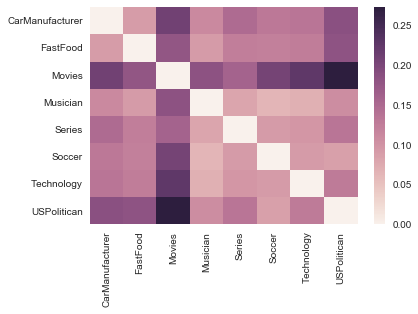

In [80]:
mean_tfidfs = []
for topic in unique_topics: 
    docs = tfidf_matrix[np.ix_(data['topic']==topic)]
    mean_tfidfs.append(np.asarray(docs.mean(axis=0))[0])

    
distance_mean_tfidfs = 1 - cosine_similarity(mean_tfidfs)
df_distance_mean_tfidfs = pd.DataFrame.from_dict(distance_mean_tfidfs).round(4)
df_distance_mean_tfidfs.columns = unique_topics
df_distance_mean_tfidfs.index = unique_topics
display(df_distance_mean_tfidfs)

sns.heatmap(df_distance_mean_tfidfs, 
            xticklabels=df_distance_mean_tfidfs.columns.values,
            yticklabels=df_distance_mean_tfidfs.columns.values)